## Implementation Using PyTorch and ODEs:

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import grad
import matplotlib.pyplot as plt

# Load China's multi-city data (S, A, I, R, D values over time)
# Placeholder for data, replace with actual data source
# Data format: time (t), city_name, S, A, I, R, D
data = pd.read_csv('china_covid_data.csv')

# Preprocessing data
# Example: Extract data for a specific city
cities = data['city_name'].unique()
time = torch.tensor(data['time'].values, dtype=torch.float32).view(-1, 1)
susceptible = torch.tensor(data['S'].values, dtype=torch.float32).view(-1, 1)
asymptomatic = torch.tensor(data['A'].values, dtype=torch.float32).view(-1, 1)
infected = torch.tensor(data['I'].values, dtype=torch.float32).view(-1, 1)
recovered = torch.tensor(data['R'].values, dtype=torch.float32).view(-1, 1)
deceased = torch.tensor(data['D'].values, dtype=torch.float32).view(-1, 1)

# Define the PINN model
class SAIRD_PINN(nn.Module):
    def __init__(self):
        super(SAIRD_PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 5)  # Outputs: S, A, I, R, D
        )
        # Parameters to estimate
        self.beta = nn.Parameter(torch.tensor(0.1))  # Initial guess for beta
        self.gamma_A = nn.Parameter(torch.tensor(0.1))  # Initial guess for gamma_A
        self.gamma_I = nn.Parameter(torch.tensor(0.1))  # Initial guess for gamma_I
        self.delta_A = nn.Parameter(torch.tensor(0.01))  # Initial guess for delta_A
        self.delta_I = nn.Parameter(torch.tensor(0.01))  # Initial guess for delta_I

    def forward(self, t):
        SAIRD = self.net(t)
        S = SAIRD[:, 0:1]
        A = SAIRD[:, 1:2]
        I = SAIRD[:, 2:3]
        R = SAIRD[:, 3:4]
        D = SAIRD[:, 4:5]
        return S, A, I, R, D

    def compute_pde(self, t):
        S, A, I, R, D = self.forward(t)
        
        # Compute derivatives using autograd
        dS_dt = grad(S, t, torch.ones_like(S), create_graph=True)[0]
        dA_dt = grad(A, t, torch.ones_like(A), create_graph=True)[0]
        dI_dt = grad(I, t, torch.ones_like(I), create_graph=True)[0]
        dR_dt = grad(R, t, torch.ones_like(R), create_graph=True)[0]
        dD_dt = grad(D, t, torch.ones_like(D), create_graph=True)[0]

        # SAIRD equations
        pde_S = dS_dt + self.beta * S * (A + I)
        pde_A = dA_dt - self.beta * S * (A + I) + self.gamma_A * A + self.delta_A * A
        pde_I = dI_dt - self.gamma_A * A + self.gamma_I * I + self.delta_I * I
        pde_R = dR_dt - self.gamma_I * I
        pde_D = dD_dt - self.delta_A * A - self.delta_I * I

        return pde_S, pde_A, pde_I, pde_R, pde_D

# Instantiate the model
model = SAIRD_PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loss function: Mean Squared Error
def loss_function(t, S_data, A_data, I_data, R_data, D_data):
    S, A, I, R, D = model(t)
    pde_S, pde_A, pde_I, pde_R, pde_D = model.compute_pde(t)
    
    data_loss = (torch.mean((S - S_data) ** 2) + 
                 torch.mean((A - A_data) ** 2) + 
                 torch.mean((I - I_data) ** 2) + 
                 torch.mean((R - R_data) ** 2) + 
                 torch.mean((D - D_data) ** 2))
    
    pde_loss = (torch.mean(pde_S ** 2) + 
                torch.mean(pde_A ** 2) + 
                torch.mean(pde_I ** 2) + 
                torch.mean(pde_R ** 2) + 
                torch.mean(pde_D ** 2))
    
    return data_loss + pde_loss

# Training loop
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(time, susceptible, asymptomatic, infected, recovered, deceased)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Beta: {model.beta.item()}, '
              f'Gamma_A: {model.gamma_A.item()}, Gamma_I: {model.gamma_I.item()}, '
              f'Delta_A: {model.delta_A.item()}, Delta_I: {model.delta_I.item()}')

# Plotting the results
time_np = time.detach().numpy()
S_pred, A_pred, I_pred, R_pred, D_pred = model(time)
S_pred = S_pred.detach().numpy()
A_pred = A_pred.detach().numpy()
I_pred = I_pred.detach().numpy()
R_pred = R_pred.detach().numpy()
D_pred = D_pred.detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(time_np, S_pred, label='Predicted Susceptible')
plt.plot(time_np, A_pred, label='Predicted Asymptomatic')
plt.plot(time_np, I_pred, label='Predicted Infected')
plt.plot(time_np, R_pred, label='Predicted Recovered')
plt.plot(time_np, D_pred, label='Predicted Deceased')
plt.scatter(time_np, susceptible, label='Actual Susceptible', s=10)
plt.scatter(time_np, asymptomatic, label='Actual Asymptomatic', s=10)
plt.scatter(time_np, infected, label='Actual Infected', s=10)
plt.scatter(time_np, recovered, label='Actual Recovered', s=10)
plt.scatter(time_np, deceased, label='Actual Deceased', s=10)
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

print(f"Estimated Beta: {model.beta.item()}")
print(f"Estimated Gamma_A: {model.gamma_A.item()}")
print(f"Estimated Gamma_I: {model.gamma_I.item()}")
print(f"Estimated Delta_A: {model.delta_A.item()}")
print(f"Estimated Delta_I: {model.delta_I.item()}")


In [31]:
import pandas as pd

df = pd.read_csv('China_deaths.csv')
df = df.drop(columns=['Provincial-level regions', '地级行政区或县级行政区', '省级行政区'])

country_infections = df.iloc[0, 1:].values.astype(float)
country_infections

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,
       nan, nan])

In [49]:
df.columns

np.float64(2.0)

In [34]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import grad
import matplotlib.pyplot as plt

# Load the dataset for I, R, and D
infected_data = pd.read_csv('China_infections.csv')  # Replace with your file path
infected_data = infected_data.drop(columns=['Provincial-level regions', '地级行政区或县级行政区', '省级行政区'])
recovered_data = pd.read_csv('China_recoveries.csv')  # Replace with your file path
recovered_data = recovered_data.drop(columns=['Provincial-level regions', '地级行政区或县级行政区', '省级行政区'])
deaths_data = pd.read_csv('China_deaths.csv')  # Replace with your file path
deaths_data = deaths_data.drop(columns=['Provincial-level regions', '地级行政区或县级行政区', '省级行政区'])

# Define the total population for all cities combined
total_population = 1411778724/3  # Approximate population of China

# Sum up the infected, recovered, and deceased cases across all cities for each day
# I_data = infected_data.iloc[:, 1:].sum(axis=0).values
# R_data = recovered_data.iloc[:, 1:].sum(axis=0).values
# D_data = deaths_data.iloc[:, 1:].sum(axis=0).values
# time = np.arange(len(I_data))

I_data = pd.to_numeric(infected_data.iloc[:, 1:].sum(axis=0), errors='coerce').fillna(0).values
R_data = pd.to_numeric(recovered_data.iloc[:, 1:].sum(axis=0), errors='coerce').fillna(0).values
D_data = pd.to_numeric(deaths_data.iloc[:, 1:].sum(axis=0), errors='coerce').fillna(0).values
time = np.arange(len(I_data))

# Convert data to torch tensors
time = torch.tensor(time, dtype=torch.float32, requires_grad=True).view(-1, 1)
I_data = torch.tensor(I_data, dtype=torch.float32).view(-1, 1)
R_data = torch.tensor(R_data, dtype=torch.float32).view(-1, 1)
D_data = torch.tensor(D_data, dtype=torch.float32).view(-1, 1)

# Assume alpha for A estimation (e.g., 0.5)
alpha = 0.25
A_data = alpha * I_data

# Estimate initial S based on total population N
N = total_population
S_data = N - I_data - R_data - D_data

# Define the PINN model for SAIRD
class SAIRD_PINN(nn.Module):
    def __init__(self):
        super(SAIRD_PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 5)  # Outputs: S, A, I, R, D
        )
        # Parameters to estimate
        self.beta = nn.Parameter(torch.tensor(0.1))  # Initial guess for beta
        self.gamma_A = nn.Parameter(torch.tensor(0.1))  # Initial guess for gamma_A
        self.gamma_I = nn.Parameter(torch.tensor(0.1))  # Initial guess for gamma_I
        self.delta_A = nn.Parameter(torch.tensor(0.01))  # Initial guess for delta_A
        self.delta_I = nn.Parameter(torch.tensor(0.01))  # Initial guess for delta_I

    def forward(self, t):
        SAIRD = self.net(t)
        S = SAIRD[:, 0:1]
        A = SAIRD[:, 1:2]
        I = SAIRD[:, 2:3]
        R = SAIRD[:, 3:4]
        D = SAIRD[:, 4:5]
        return S, A, I, R, D

    def compute_pde(self, t):
        S, A, I, R, D = self.forward(t)
        
        # Compute derivatives using autograd
        dS_dt = grad(S, t, torch.ones_like(S), create_graph=True)[0]
        dA_dt = grad(A, t, torch.ones_like(A), create_graph=True)[0]
        dI_dt = grad(I, t, torch.ones_like(I), create_graph=True)[0]
        dR_dt = grad(R, t, torch.ones_like(R), create_graph=True)[0]
        dD_dt = grad(D, t, torch.ones_like(D), create_graph=True)[0]

        # SAIRD equations
        pde_S = dS_dt + self.beta * S * (A + I) / N
        pde_A = dA_dt - self.beta * S * (A + I) / N + self.gamma_A * A + self.delta_A * A
        pde_I = dI_dt - self.gamma_A * A + self.gamma_I * I + self.delta_I * I
        pde_R = dR_dt - self.gamma_I * I
        pde_D = dD_dt - self.delta_A * A - self.delta_I * I

        return pde_S, pde_A, pde_I, pde_R, pde_D

# Instantiate the model
model = SAIRD_PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
def loss_function(t, S_data, A_data, I_data, R_data, D_data):
    S, A, I, R, D = model(t)
    pde_S, pde_A, pde_I, pde_R, pde_D = model.compute_pde(t)
    
    data_loss = (torch.mean((S - S_data) ** 2) + 
                 torch.mean((A - A_data) ** 2) + 
                 torch.mean((I - I_data) ** 2) + 
                 torch.mean((R - R_data) ** 2) + 
                 torch.mean((D - D_data) ** 2))
    
    pde_loss = (torch.mean(pde_S ** 2) + 
                torch.mean(pde_A ** 2) + 
                torch.mean(pde_I ** 2) + 
                torch.mean(pde_R ** 2) + 
                torch.mean(pde_D ** 2))
    
    return data_loss + pde_loss

# Training loop
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(time, S_data, A_data, I_data, R_data, D_data)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Beta: {model.beta.item()}, '
              f'Gamma_A: {model.gamma_A.item()}, Gamma_I: {model.gamma_I.item()}, '
              f'Delta_A: {model.delta_A.item()}, Delta_I: {model.delta_I.item()}')

# Display the estimated parameters
print("\nFinal Estimated Parameters:")
print(f"Estimated Beta: {model.beta.item()}")
print(f"Estimated Gamma_A: {model.gamma_A.item()}")
print(f"Estimated Gamma_I: {model.gamma_I.item()}")
print(f"Estimated Delta_A: {model.delta_A.item()}")
print(f"Estimated Delta_I: {model.delta_I.item()}")


Epoch 0, Loss: 2.214551623911342e+17, Beta: 0.09999928623437881, Gamma_A: 0.10100000351667404, Gamma_I: 0.0989999994635582, Delta_A: 0.009000000543892384, Delta_I: 0.009000000543892384
Epoch 500, Loss: 2.2145512803139584e+17, Beta: -0.390389084815979, Gamma_A: 0.04876697435975075, Gamma_I: 5.9420635807327926e-05, Delta_A: -0.048775993287563324, Delta_I: 0.050099220126867294
Epoch 1000, Loss: 2.2145511085152666e+17, Beta: -0.8205052614212036, Gamma_A: 0.04929366335272789, Gamma_I: 1.8500370060792193e-05, Delta_A: -0.04937499761581421, Delta_I: 0.04914756491780281
Epoch 1500, Loss: 2.214550593119191e+17, Beta: -1.0674132108688354, Gamma_A: 0.04967473819851875, Gamma_I: -7.412245395244099e-06, Delta_A: -0.04959115386009216, Delta_I: 0.04864512011408806
Epoch 2000, Loss: 2.2145504213204992e+17, Beta: -1.182985782623291, Gamma_A: 0.04990466684103012, Gamma_I: -1.808617525966838e-05, Delta_A: -0.049926161766052246, Delta_I: 0.048195842653512955
Epoch 2500, Loss: 2.2145500777231155e+17, Beta:

In [40]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load the datasets
infections = pd.read_csv('China_infections.csv')
infections = infections.drop(columns=['Provincial-level regions', '地级行政区或县级行政区', '省级行政区'])
recoveries = pd.read_csv('China_recoveries.csv')
recoveries = recoveries.drop(columns=['Provincial-level regions', '地级行政区或县级行政区', '省级行政区'])
deaths = pd.read_csv('China_deaths.csv')
deaths = deaths.drop(columns=['Provincial-level regions', '地级行政区或县级行政区', '省级行政区'])

# Assume we are focusing on country-level data
# country_infections = infections.iloc[1, 1:].values.astype(float)
# country_recoveries = recoveries.iloc[1, 1:].values.astype(float)
# country_deaths = deaths.iloc[1, 1:].values.astype(float)
dates = infections.columns[1:]

country_infections = infections.iloc[1:, 1:].sum(axis=0).values.astype(float)
country_recoveries = recoveries.iloc[1:, 1:].sum(axis=0).values.astype(float)
country_deaths = deaths.iloc[1:, 1:].sum(axis=0).values.astype(float)

# Convert the dates to a numerical scale (days since the first date)
time = np.arange(len(dates))

# Convert data to tensors
time_tensor = torch.tensor(time, dtype=torch.float32).reshape(-1, 1)
infections_tensor = torch.tensor(country_infections, dtype=torch.float32).reshape(-1, 1)
recoveries_tensor = torch.tensor(country_recoveries, dtype=torch.float32).reshape(-1, 1)
deaths_tensor = torch.tensor(country_deaths, dtype=torch.float32).reshape(-1, 1)


In [41]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 5)  # Outputs: S, A, I, R, D
        )
        
        # Separate networks for time-varying parameters
        self.beta1 = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 1))
        self.beta2 = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 1))
        self.gamma1 = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 1))
        self.gamma2 = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 1))
        self.gamma3 = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 1))
        self.kappa1 = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 1))
        self.kappa2 = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 1))
        self.mu = nn.Sequential(nn.Linear(1, 10), nn.Tanh(), nn.Linear(10, 1))
        self.Lambda = nn.Parameter(torch.tensor(1.0))  # Learnable constant
    
    def forward(self, t):
        # Predict S, A, I, R, D
        S, A, I, R, D = self.net(t).T
        
        # Predict parameters as functions of time
        beta1 = self.beta1(t)
        beta2 = self.beta2(t)
        gamma1 = self.gamma1(t)
        gamma2 = self.gamma2(t)
        gamma3 = self.gamma3(t)
        kappa1 = self.kappa1(t)
        kappa2 = self.kappa2(t)
        mu = self.mu(t)
        
        return S, A, I, R, D, beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu


In [42]:
def pinn_loss(model, t, infections, recoveries, deaths):
    S, A, I, R, D, beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu = model(t)
    
    # Compute derivatives using automatic differentiation
    S_t = torch.autograd.grad(S.sum(), t, create_graph=True)[0]
    A_t = torch.autograd.grad(A.sum(), t, create_graph=True)[0]
    I_t = torch.autograd.grad(I.sum(), t, create_graph=True)[0]
    R_t = torch.autograd.grad(R.sum(), t, create_graph=True)[0]
    D_t = torch.autograd.grad(D.sum(), t, create_graph=True)[0]

    # Define the differential equations based on the SAIRD model
    f1 = S_t - (model.Lambda - beta1 * S * A - beta2 * S * I - mu * S)
    f2 = A_t - (beta1 * S * A - (gamma1 + gamma2 + gamma3) * A - mu * A)
    f3 = I_t - (beta2 * S * I + gamma1 * A - (kappa1 + kappa2) * I - mu * I)
    f4 = R_t - (gamma2 * A + kappa1 * I - mu * R)
    f5 = D_t - (gamma3 * A + kappa2 * I)
    
    # Data loss (MSE)
    data_loss = (I - infections).pow(2).mean() + (R - recoveries).pow(2).mean() + (D - deaths).pow(2).mean()
    
    # Physics loss (MSE)
    physics_loss = f1.pow(2).mean() + f2.pow(2).mean() + f3.pow(2).mean() + f4.pow(2).mean() + f5.pow(2).mean()
    
    # Total loss
    return data_loss + physics_loss


In [47]:
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Enable gradient tracking for time
time_tensor.requires_grad = True

# Training loop
epochs = 50000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = pinn_loss(model, time_tensor, infections_tensor, recoveries_tensor, deaths_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 10762674.0
Epoch 100, Loss: 10714780.0
Epoch 200, Loss: 10677808.0
Epoch 300, Loss: 10642550.0
Epoch 400, Loss: 10608230.0
Epoch 500, Loss: 10574541.0
Epoch 600, Loss: 10541354.0
Epoch 700, Loss: 10508589.0
Epoch 800, Loss: 10476198.0
Epoch 900, Loss: 10444147.0
Epoch 1000, Loss: 10412406.0
Epoch 1100, Loss: 10380957.0
Epoch 1200, Loss: 10349779.0
Epoch 1300, Loss: 10318861.0
Epoch 1400, Loss: 10288189.0
Epoch 1500, Loss: 10257752.0
Epoch 1600, Loss: 10227543.0
Epoch 1700, Loss: 10197550.0
Epoch 1800, Loss: 10167773.0
Epoch 1900, Loss: 10138203.0
Epoch 2000, Loss: 10108834.0
Epoch 2100, Loss: 10079665.0
Epoch 2200, Loss: 10050692.0
Epoch 2300, Loss: 10021912.0
Epoch 2400, Loss: 9993322.0
Epoch 2500, Loss: 9964918.0
Epoch 2600, Loss: 9936700.0
Epoch 2700, Loss: 9908664.0
Epoch 2800, Loss: 9880807.0
Epoch 2900, Loss: 9853131.0
Epoch 3000, Loss: 9825632.0
Epoch 3100, Loss: 9798308.0
Epoch 3200, Loss: 9771159.0
Epoch 3300, Loss: 9744181.0
Epoch 3400, Loss: 9717376.0
Epoch 35

TypeError: unhashable type: 'numpy.ndarray'

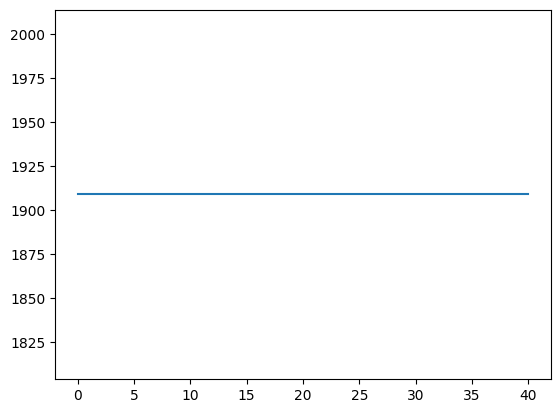

In [48]:
with torch.no_grad():
    S, A, I, R, D, beta1, beta2, gamma1, gamma2, gamma3, kappa1, kappa2, mu = model(time_tensor)
    plt.plot(time, I, label='Predicted Infections')
    plt.plot(time, infections, label='Actual Infections')
    plt.xlabel('Time (days)')
    plt.ylabel('Infections')
    plt.legend()
    plt.show()
